In [1]:
%matplotlib inline


# Voice Activity Detection

### Plot VAD in sound and remove silences.

Currently PySoundTool has two base functions to complete voice-activity-detection.

1) `pysoundtool.dsp.sound_index`
--------------------------------

This function is used in:

`pysoundtool.feats.get_stft_clipped` 

`pysoundtool.feats.get_samples_clipped`

`pysoundtool.feats.plot_vad`


This form of VAD uses the energy in the signal to identify when sounds start and 
end, relative to the beginning and end of the entire sample. 
(It does not identify silences between sounds, as of yet.)

* Strength:


This is quite reliable across noise and speaker variety, especially when combined with 
the Wiener filter. It also catches a significant portion of the speech signal
that is identified.

* Weakness:


This is less sensitive to certain speech sounds such as fricatives (s, f, h, etc.), causing it to miss speech activity consisting primarily of these sounds.


2) `pysoundtool.dsp.vad`
------------------------

This function is used in:

`pysoundtool.feats.get_vad_stft`

`pysoundtool.feats.get_vad_samples`

`pysoundtool.feats.plot_vad`

This function (pulling from research) utilizes energy, frequency, and spectral flatness, 
which makes it less finicky when it comes to speech sounds (fricative vs plosive speech sounds). 
However, it is sometimes not sensitive enough to pick up general speech and 
when it does, it does not pick up as much of the entire speech signal.

* Strength:

This examines speech / sound activity throughout the signal, not just when it starts and ends.
It is also more sensitive to a variety of speech sounds, not just those with high energy.

* Weakness:

With certain speakers / background sounds, the VAD is more or less sensitive, and difficult to 
predict.

## Note

These may be used together and / or with a Wiener filter to balance out the strengths and 
weaknesses of each. One can also apply a `extend_window_ms` to broaden
the VAD identified.

In [2]:
import os, sys
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
packagedir = os.path.dirname(currentdir)
sys.path.insert(0, packagedir)

import pysoundtool as pyso 
import numpy as np
import IPython.display as ipd

package_dir = '../'
os.chdir(package_dir)
pyso_dir = './'

# Load sample speech audio

We will look at how these two options handle two different speech samples. 
The speech samples will be combined but separated by a silence. 
They will also be altered with white noise.



### "Python"

Note: this file is available in the PySoundTool repo.


In [6]:
# VAD and filtering work best with high sample rates (48000)
sr = 48000
python = '{}audiodata/python.wav'.format(pyso_dir, sr=sr)
y_p, sr = pyso.loadsound(python, sr=sr)
ipd.Audio(y_p, rate = sr)

### "Six"

This is a sample file from the speech commands dataset 
(Attribution 4.0 International (CC BY 4.0))
dataset: https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.htmll
license: https://creativecommons.org/licenses/by/4.0/

This is audio that has two fricatives in it: 's' and 'x'
which will show to cause issues as noise increases.

In [8]:
six = '{}audiodata/six.wav'.format(pyso_dir, sr = sr)
y_six, sr = pyso.loadsound(six, sr = sr)
ipd.Audio(y_six,rate = sr)

# Combine the speech samples and add noise


### Combine speech signals with silence between

This is to show the strengths and weaknesses of both VAD techniques.



/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/pysoundtool/dsp.py:633: UserWarning: 

  warnings.warn(msg)
/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/update_env/lib/python3.6/site-packages/scipy/stats/stats.py:338: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/pysoundtool/dsp.py:2644: RuntimeWarning: divide by zero encountered in log10
  sfm = 10 * np.log10(g/(a+1e-6))
/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/pysoundtool/dsp.py:511: UserWarning: The length of `audio_main` and `pad_mainsound_sec `exceeds `total_len_sec`. 1 samples from `audio_main` will be cut off in the `combined` audio signal.
  'the `combined` audio signal.')


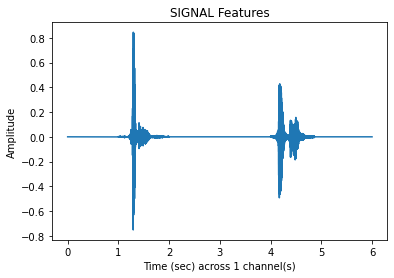

In [9]:
p_silence = np.zeros(len(y_p))
y_p_long, snr_none = pyso.dsp.add_backgroundsound(y_p, p_silence,
                                        sr = sr, 
                                        snr = None,
                                        pad_mainsound_sec = 1,
                                        total_len_sec = 3,
                                        random_seed = 40)
y_six_long, snr_none = pyso.dsp.add_backgroundsound(y_six, p_silence,
                                        sr = sr, 
                                        snr = None,
                                        pad_mainsound_sec = 1,
                                        total_len_sec = 3,
                                        random_seed = 40)
y = np.concatenate((y_six_long, y_p_long))
pyso.feats.plot(y, sr=sr, feature_type = 'signal')
ipd.Audio(y, rate=sr)

# Generate white noise 

In [10]:
white_noise = pyso.dsp.generate_noise(len(y), random_seed = 40)

# Generate speech audio at various SNR levels

## Speech and Noise SNR 20

In [11]:
y_snr20, snr20 = pyso.dsp.add_backgroundsound(
    y, white_noise, sr=sr, snr = 20,random_seed = 40)
# round the measured snr:
snr20 = int(round(snr20))
snr20

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/pysoundtool/dsp.py:633: UserWarning: 

  warnings.warn(msg)


20

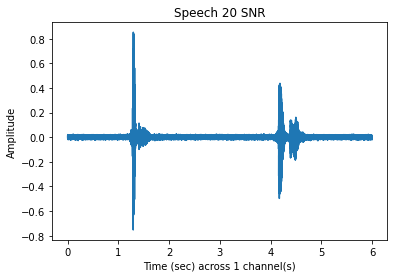

In [12]:
pyso.plotsound(y_snr20, sr = sr, feature_type = 'signal', 
               title = 'Speech {} SNR'.format(snr20))
ipd.Audio(y_snr20,rate=sr)

## Speech and Noise SNR 5

In [25]:
y_snr05, snr5 = pyso.dsp.add_backgroundsound(
    y, white_noise, sr=sr, snr = 5,random_seed = 40)
# round the measured snr:
snr5 = int(round(snr5))
snr5

5

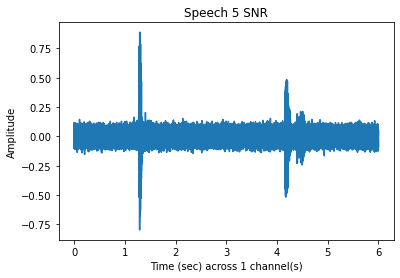

In [26]:
pyso.plotsound(y_snr05, sr = sr, feature_type = 'signal', 
               title = 'Speech {} SNR'.format(snr5))
ipd.Audio(y_snr5,rate=sr)

# Plot Voice Activity

### Graph Note: 
* If no VAD, yellow dots are placed at the bottom. 
* If VAD, yellow dots are placed at the top.

## Set window size

For increased frequency definition, a longer window is suggested



In [15]:
win_size_ms = 50

## Set percent overlap

Percent overlap is how much each consecutive window (size `win_size_ms`) overlaps.
These VAD functions can be reliably used at 0 and 0.5 `percent_overlap`.
VAD does not need overlapping samples; however, better performance
tends to occur with 0.5



In [16]:
percent_overlap = 0.5

## Set background noise reference

For measuring background noise in signal, set amount 
of beginning noise in milliseconds to use. Currently, this is 
only relevant for `pysoundtool.dsp.vad`.



In [17]:
use_beg_ms = 120

## VAD (SNR 20)

## Option 1:
### Cut off beginning and ending silences

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/update_env/lib/python3.6/site-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


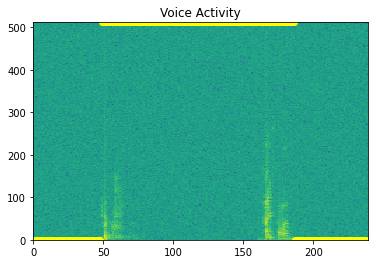

In [18]:
pyso.feats.plot_vad(y_snr20, sr=sr, beg_end_clipped = True,
                    percent_overlap = percent_overlap, 
                    win_size_ms = win_size_ms)

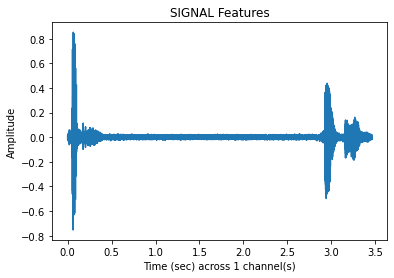

In [19]:
clipped_samples, vad_matrix = pyso.feats.get_samples_clipped(y_snr20, sr=sr, percent_overlap = percent_overlap, 
                   win_size_ms = win_size_ms)
pyso.feats.plot(clipped_samples, sr=sr, feature_type = 'signal')
ipd.Audio(clipped_samples, rate= sr)

## Option 2:

### Check VAD through entire signal

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/update_env/lib/python3.6/site-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


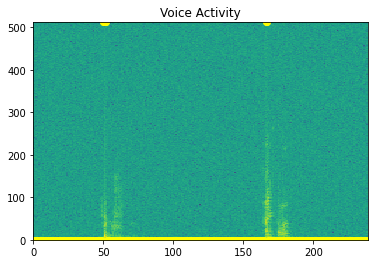

In [20]:
pyso.feats.plot_vad(y_snr20, sr=sr, beg_end_clipped = False,
                    percent_overlap = 0.5, 
                    win_size_ms = win_size_ms)

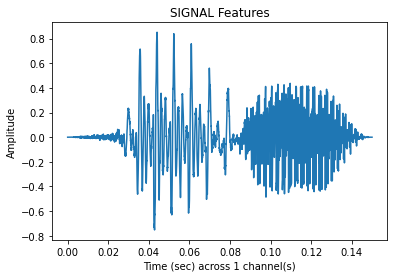

In [21]:
vad_samples, vad_matrix = pyso.feats.get_vad_samples(
    y_snr20, sr=sr, use_beg_ms = use_beg_ms, 
    percent_overlap = percent_overlap, win_size_ms = win_size_ms)
pyso.feats.plot(vad_samples, sr=sr, feature_type = 'signal')
ipd.Audio(vad_samples, rate = sr)

### Improves with Wiener filter and padding?

see `pysoundtool.filtersignal`

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/update_env/lib/python3.6/site-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


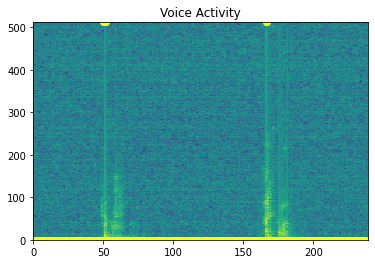

In [43]:
y_snr20_wf, sr = pyso.filtersignal(
    y_snr20, sr=sr, apply_postfilter = False)

pyso.feats.plot_vad(y_snr20_wf, sr=sr, beg_end_clipped = False,
                    percent_overlap = percent_overlap, 
                    win_size_ms = win_size_ms)

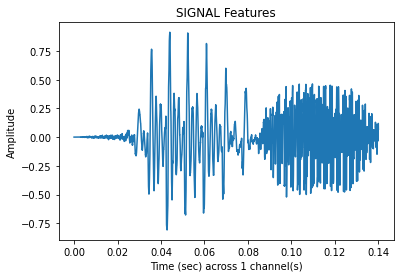

In [47]:
vad_samples, vad_matrix = pyso.feats.get_vad_samples(
    y_snr20_wf, sr=sr, percent_overlap = percent_overlap, 
    win_size_ms = win_size_ms)
pyso.feats.plot(vad_samples, sr=sr, feature_type = 'signal')
ipd.Audio(vad_samples, rate= sr)

### No improvement with Wiener filter..

### Let's extend / pad the window of VAD by 300 ms

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/update_env/lib/python3.6/site-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


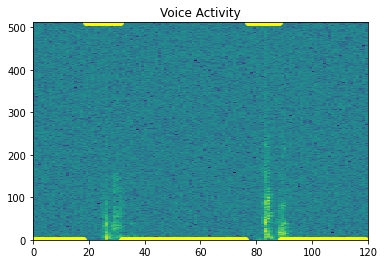

In [22]:
pyso.feats.plot_vad(y_snr20, sr=sr, beg_end_clipped = False,
                   extend_window_ms = 300, use_beg_ms = use_beg_ms, 
                    percent_overlap = 0, win_size_ms = win_size_ms)

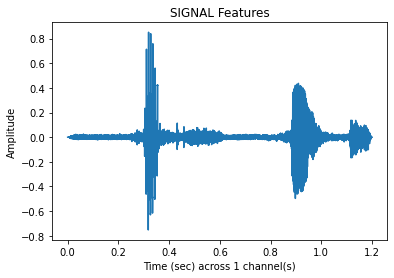

In [23]:
vad_samples, vad_matrix = pyso.feats.get_vad_samples(
    y_snr20, sr=sr, use_beg_ms = use_beg_ms, extend_window_ms = 300,
    percent_overlap = 0.5, win_size_ms = win_size_ms)
pyso.feats.plot(vad_samples, sr=sr, feature_type = 'signal')
ipd.Audio(vad_samples, rate = sr)

## VAD (SNR 5)

## Option 1:
### Cut off beginning and ending silences

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/update_env/lib/python3.6/site-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


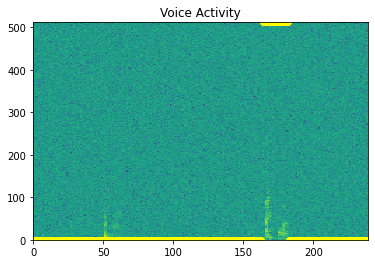

In [27]:
pyso.feats.plot_vad(y_snr05, sr=sr, beg_end_clipped = True, 
                    percent_overlap = percent_overlap, 
                    win_size_ms = win_size_ms)

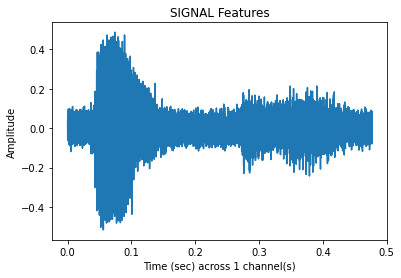

In [28]:
clipped_samples, vad_matrix = pyso.feats.get_samples_clipped(y_snr05, sr=sr, percent_overlap = percent_overlap, 
                   win_size_ms = win_size_ms)
pyso.feats.plot(clipped_samples, sr=sr, feature_type = 'signal')
ipd.Audio(clipped_samples, rate= sr)

### Improves with Wiener filter and padding?

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/update_env/lib/python3.6/site-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


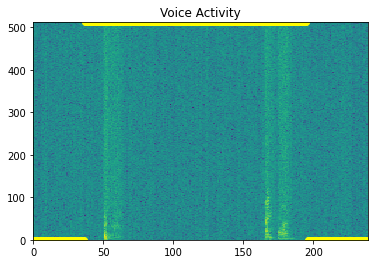

In [29]:
y_snr05_wf, sr = pyso.filtersignal(
    y_snr05, sr=sr, apply_postfilter = True)

pyso.feats.plot_vad(y_snr05_wf, sr=sr, beg_end_clipped = True,
                    percent_overlap = percent_overlap, 
                    win_size_ms = win_size_ms, extend_window_ms = 300)

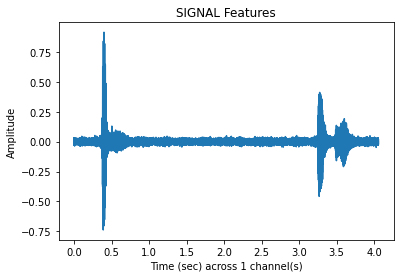

In [46]:
clipped_samples, vad_matrix = pyso.feats.get_samples_clipped(
    y_snr05_wf, sr=sr, percent_overlap = percent_overlap, 
    win_size_ms = win_size_ms, extend_window_ms = 300)
pyso.feats.plot(clipped_samples, sr=sr, feature_type = 'signal')
ipd.Audio(clipped_samples, rate= sr)

## Option 2:

### Check VAD through entire signal

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/update_env/lib/python3.6/site-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


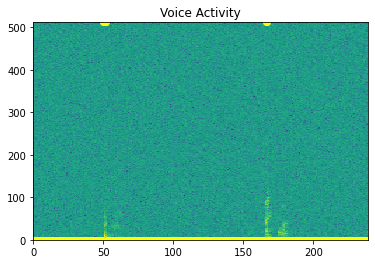

In [31]:
pyso.feats.plot_vad(y_snr05, sr=sr, beg_end_clipped = False,
                    percent_overlap = 0.5, win_size_ms = win_size_ms)

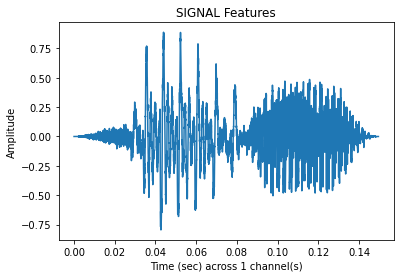

In [32]:
vad_samples, vad_matrix = pyso.feats.get_vad_samples(
    y_snr05, sr=sr, use_beg_ms = use_beg_ms, 
    percent_overlap = 0.5, win_size_ms = win_size_ms)
pyso.feats.plot(vad_samples, sr=sr, feature_type = 'signal')
ipd.Audio(vad_samples, rate = sr)

### Improves with Wiener filter and padding?

See `pysoundtool.builtin.filtersignal`

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/update_env/lib/python3.6/site-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


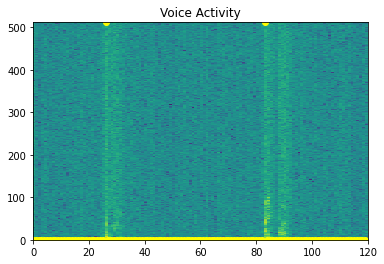

In [36]:
pyso.feats.plot_vad(y_snr05_wf, sr=sr, beg_end_clipped = False, use_beg_ms = use_beg_ms, 
                    percent_overlap = 0, win_size_ms = win_size_ms)

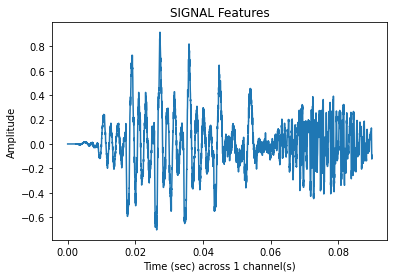

In [37]:
vad_samples, vad_matrix = pyso.feats.get_vad_samples(
    y_snr05_wf, sr=sr, use_beg_ms = use_beg_ms,
    percent_overlap = 0.5, win_size_ms = win_size_ms)
pyso.feats.plot(vad_samples, sr=sr, feature_type = 'signal')
ipd.Audio(vad_samples, rate = sr)

### No improvement with Wiener filter

### Let's extend / pad the window of VAD

/home/airos/Projects/github/a-n-rose/Python-Sound-Tool/update_env/lib/python3.6/site-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


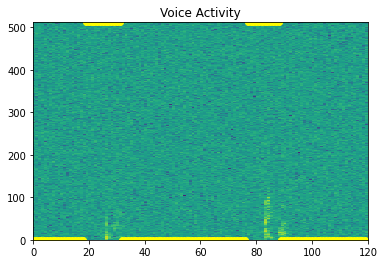

In [33]:
pyso.feats.plot_vad(y_snr05, sr=sr, beg_end_clipped = False,
                    extend_window_ms = 300, use_beg_ms = use_beg_ms, 
                    percent_overlap = 0, win_size_ms = win_size_ms)

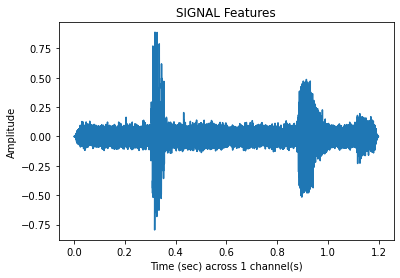

In [34]:
vad_samples, vad_matrix = pyso.feats.get_vad_samples(
    y_snr05, sr=sr, use_beg_ms = use_beg_ms, extend_window_ms = 300,
    percent_overlap = 0.5, win_size_ms = win_size_ms)
pyso.feats.plot(vad_samples, sr=sr, feature_type = 'signal')
ipd.Audio(vad_samples, rate = sr)

In Sum
------
We can see from the above examples that the first option (clipping beginning 
and ending silences) works pretty well at higher SNRs and with filtering. 
It identified pretty well when the speech began and ended.


The second option (VAD throughout the signal) was perhaps better able 
to identify the existence of speech despite noise (without filtering); 
however, it only recognized a very small portion of it. 



Despite these functions being a work in progress, I have found them 
to be quite useful when working with audio data for deep learning and 
other sound related projects.

